# Optimization

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
from sklearn.svm import SVC  
from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report

### Data generation

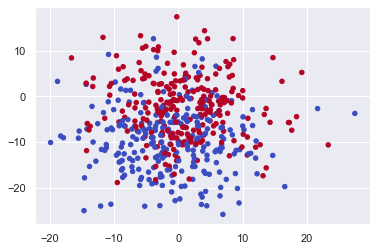

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(500, 2, centers=2, random_state=2, cluster_std=7)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='coolwarm')

In [ ]:
'''
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons
X, y = make_circles(n_samples=500, noise=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='coolwarm');
'''

## 1. SGD 알고리즘
### 자료 표준화, SGD 디폴트 모델 파이프라인으로 적용

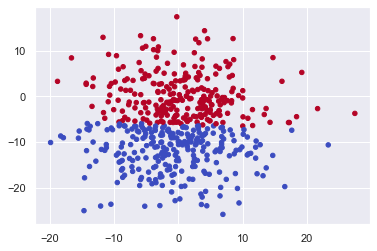

In [4]:
pipe = Pipeline([('scaler',StandardScaler()), ('svm', SGDClassifier(random_state=11))]) # nickname
pipe = make_pipeline(StandardScaler(), SGDClassifier(random_state=11)) # 약식으로
pipe.fit(X, y)

y_predict = pipe.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_predict, s=20, cmap='coolwarm');

In [5]:
print(classification_report(y, y_predict))

              precision    recall  f1-score   support

           0       0.70      0.71      0.70       250
           1       0.70      0.70      0.70       250

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.70       500
weighted avg       0.70      0.70      0.70       500



### 교차검증과 하이퍼파라미터

In [6]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
kf = KFold(n_splits=5, random_state=11)

In [12]:
pipe.named_steps

{'standardscaler': StandardScaler(),
 'sgdclassifier': SGDClassifier(random_state=11)}

In [9]:
pipe.named_steps['sgdclassifier'].get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 11,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [13]:
pipe.named_steps

{'standardscaler': StandardScaler(),
 'sgdclassifier': SGDClassifier(random_state=11)}

In [14]:
param_dist = {
    'sgdclassifier__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate, uniform pdf형태로도 가능
    'sgdclassifier__max_iter': [100, 500, 1000, 1500], # number of epochs
    'sgdclassifier__loss': ['hinge', 'log', 'perceptron', 'modified_huber'], # logistic regression,
    'sgdclassifier__penalty': ['l1','l2'] # lasso, ridge
}

In [15]:
rs = RandomizedSearchCV(pipe, param_distributions= param_dist, cv=kf,
                        n_iter=50, 
                        scoring='accuracy', verbose=True)
rs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.4s finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=11, shuffle=False),
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('sgdclassifier',
                                              SGDClassifier(random_state=11))]),
                   n_iter=50,
                   param_distributions={'sgdclassifier__alpha': [0.0001, 0.001,
                                                                 0.01, 0.1, 1.0,
                                                                 10.0, 100.0,
                                                                 1000.0],
                                        'sgdclassifier__loss': ['hinge', 'log',
                                                                'perceptron',
                                                                'modified_huber'],
                                        'sgdclassifier__max_iter': [10

In [16]:
rs.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.1, loss='log', max_iter=500,
                               random_state=11))])

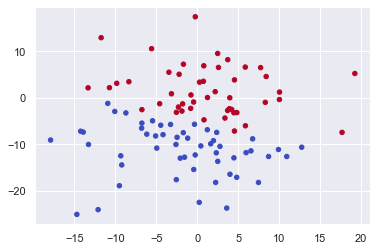

In [17]:
y_predict = rs.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_predict, s=20, cmap='coolwarm');

In [18]:
rs.decision_function(X_test[0:10])
rs.predict_proba(X_test[0:10])

array([-0.24718458, -0.44108963, -0.08012509, -0.5005804 ,  0.54018953,
        1.34090574,  0.2323918 , -0.68680685, -0.68041988, -1.21592726])

array([[0.56148341, 0.43851659],
       [0.60851864, 0.39148136],
       [0.52002056, 0.47997944],
       [0.62259572, 0.37740428],
       [0.36814349, 0.63185651],
       [0.20736115, 0.79263885],
       [0.44216211, 0.55783789],
       [0.66525622, 0.33474378],
       [0.6638324 , 0.3361676 ],
       [0.77134603, 0.22865397]])

In [19]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.64      0.77      0.70        44
           1       0.79      0.66      0.72        56

    accuracy                           0.71       100
   macro avg       0.71      0.72      0.71       100
weighted avg       0.72      0.71      0.71       100



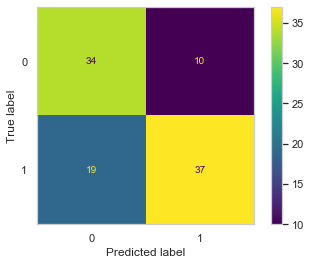

In [20]:
sns.set_style("whitegrid", {'axes.grid' : False})
plot_confusion_matrix(rs, X_test, y_test)

- 양수이면 positive, 음수이면 negative로 데이터를 분류하고 예측
        * 음수와 양수의 절대값의 크기가 클수록 의사결정선(decesion boundary)에서 멀어지게 되어 자신있게 예측

positive(1)의 개수는 47


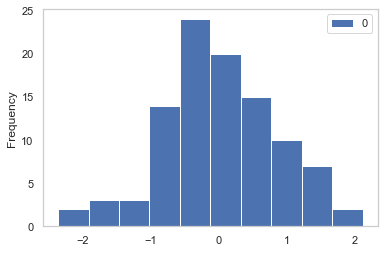

In [21]:
print(f'positive(1)의 개수는 {np.sum(rs.decision_function(X_test) > 0)}')
pd.DataFrame(rs.decision_function(X_test)).plot(kind='hist')

- 극단의 negative와 positive가 될 것 같은 데이터를 예측하면

In [22]:
rs.predict(np.array([[-20.0, -20.0]]))
rs.decision_function(np.array([[-20.0, -20.0]]))
rs.predict(np.array([[20.0, 20.0]]))
rs.decision_function(np.array([[20.0, 20.0]]))

array([0])

array([-2.08266888])

array([1])

array([3.10228911])

## 2. 로지스틱 회귀 알고리즘

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

In [24]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('poly', PolynomialFeatures()),
                 ('lgr', LogisticRegression(random_state=11))
                ]) # nickname

In [25]:
PolynomialFeatures().get_params()
LogisticRegression(random_state=11).get_params()

{'degree': 2, 'include_bias': True, 'interaction_only': False, 'order': 'C'}

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 11,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [26]:
params = {'poly__degree': np.arange(1,30),
          'lgr__C': np.logspace(-4, 4, 20), 
          'lgr__penalty': ['l1', 'l2']}
rs = RandomizedSearchCV(pipe, param_distributions=params, cv=kf,
                          scoring = 'accuracy')
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=11, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('poly', PolynomialFeatures()),
                                             ('lgr',
                                              LogisticRegression(random_state=11))]),
                   param_distributions={'lgr__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'lgr__penalty': ['l1', 'l2'],
                                        'poly__degree': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 2

In [27]:
rs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(degree=11)),
                ('lgr',
                 LogisticRegression(C=78.47599703514607, random_state=11))])

In [28]:
rs.best_estimator_.named_steps['lgr'].get_params()

{'C': 78.47599703514607,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 11,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [29]:
rs.best_estimator_.named_steps['lgr'].coef_ # log(odds)

array([[ 6.52154990e-05,  7.98094529e-04,  2.35724682e-03,
        -4.17404261e-04, -2.19292234e-04,  5.48801122e-04,
         8.39341729e-04,  1.60949147e-03,  4.37773982e-04,
         3.06165972e-03, -5.21847714e-04, -2.00328939e-04,
        -1.00506785e-05, -5.72845459e-04,  1.18256373e-03,
         8.98576901e-04,  2.11325463e-03,  6.79686626e-04,
         1.83092584e-03,  4.66219820e-04,  5.47494865e-03,
         2.83170662e-04,  8.28837286e-05, -4.76396750e-05,
        -5.77427967e-04,  2.98026454e-04, -1.10044142e-03,
         2.53118185e-03,  8.80431241e-04,  4.04520545e-03,
         1.07601151e-03,  1.83266351e-03,  1.37704585e-03,
         2.85734710e-03,  7.34615376e-04,  1.11977194e-02,
         3.73744319e-03,  1.44969892e-03,  3.84627789e-04,
        -7.69350172e-04,  1.76768344e-04, -3.76979059e-04,
         5.97330923e-04, -1.77431208e-03,  3.61077273e-03,
         1.35740238e-03,  8.65824591e-03,  1.01054735e-03,
         3.10227321e-03,  3.55509296e-03,  1.47640814e-0

In [30]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.64      0.77      0.70        44
           1       0.79      0.66      0.72        56

    accuracy                           0.71       100
   macro avg       0.71      0.72      0.71       100
weighted avg       0.72      0.71      0.71       100



로지스틱 회귀의 하이퍼파라미터인 ‘solver’ 유형에는 ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’가 있다. 데이터의 크기, 이항과 다항 분류방식에 따라 L1과 L2 패널티를 부여하는 조합이 다르다. 사이킷런은 이항과 다항분류, ‘solver’ 유형별로 가능한 하이퍼파라미터의 조합을 https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 제시하고 있다. 가능하지 않은 조합으로 예측을 하게 되면 에러 메시지가 나올 수 있는데, 이런 경우에 참고하여 하이퍼파라미터를 수정한다.

## 3. GNB

In [39]:
from sklearn.naive_bayes import GaussianNB
np.random.seed(1357)
model = GaussianNB()
params = {}
rs = RandomizedSearchCV(model, params, cv=kf, scoring = 'recall_macro')
rs.fit(X_train, y_train)

TypeError: __init__() got an unexpected keyword argument 'probability'

In [40]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.64      0.77      0.70        44
           1       0.79      0.66      0.72        56

    accuracy                           0.71       100
   macro avg       0.71      0.72      0.71       100
weighted avg       0.72      0.71      0.71       100



## 4. SVM
- SVM 알고리즘은 최적해에 수렴하지 않을 수도 있기 떄문에 'max_iter'옵션을 준다

In [41]:
from sklearn.svm import SVC 
#pipe = make_pipeline(StandardScaler(), SVC(max_iter=1000, random_state=11)) # 약식으로
pipe = make_pipeline(StandardScaler(), SVC(max_iter=1000, probability=True, random_state=11))

pipe
pipe.named_steps['svc'].get_params()

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(max_iter=1000, probability=True, random_state=11))])

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': 1000,
 'probability': True,
 'random_state': 11,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

- hyperparameter 의 종류
   * 1. Kernels 종류
   * 2. margin의 폭
   * 3. 커널의 파라미터, Gaussian RBF 커널인 경우 분산의 크기, 분산이 크면 멀리 있는 데이터도 중요시함
}

In [42]:
param_grid = {
    'svc__kernel': ['poly', 'rbf', 'sigmoid', 'linear'], # Kernels 종류
    'svc__C': np.arange(0.01, 100), # margin의 폭
    'svc__gamma': np.arange(0.01, 100) # 커널의 파라미터, Gaussian RBF 커널인 경우 분산의 크기, 분산이 크면 멀리 있는 데이터도 중요시함
}

In [43]:
rs = RandomizedSearchCV(pipe, param_grid, cv=kf, scoring = 'accuracy')
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=11, shuffle=False),
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svc',
                                              SVC(max_iter=1000,
                                                  probability=True,
                                                  random_state=11))]),
                   param_distributions={'svc__C': array([1.000e-02, 1.010e+00, 2.010e+00, 3.010e+00, 4.010e+00, 5.010e+00,
       6.010e+00, 7.010e+00, 8.010e+00, 9.010e+00, 1.001e+01, 1.101e+01...
       7.201e+01, 7.301e+01, 7.401e+01, 7.501e+01, 7.601e+01, 7.701e+01,
       7.801e+01, 7.901e+01, 8.001e+01, 8.101e+01, 8.201e+01, 8.301e+01,
       8.401e+01, 8.501e+01, 8.601e+01, 8.701e+01, 8.801e+01, 8.901e+01,
       9.001e+01, 9.101e+01, 9.201e+01, 9.301e+01, 9.401e+01, 9.501e+01,
       9.601e+01, 9.701e+01, 9.801e+01, 9.901e+01])

In [44]:
rs.best_estimator_.predict(X_test)[0:10]
rs.best_estimator_.decision_function(X_test)[0:10]
rs.best_estimator_.predict_proba(X_test)[0:10]

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0])

array([ 0.05355222,  0.39919015, -0.11760094, -0.87458673,  1.05306272,
        1.27481295,  0.03020949,  1.13205101,  1.18566107, -1.21881229])

array([[0.36754261, 0.63245739],
       [0.29730981, 0.70269019],
       [0.40808442, 0.59191558],
       [0.58617138, 0.41382862],
       [0.18520181, 0.81479819],
       [0.15544205, 0.84455795],
       [0.37310341, 0.62689659],
       [0.17412751, 0.82587249],
       [0.1669116 , 0.8330884 ],
       [0.66000267, 0.33999733]])

In [45]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.64      0.77      0.70        44
           1       0.79      0.66      0.72        56

    accuracy                           0.71       100
   macro avg       0.71      0.72      0.71       100
weighted avg       0.72      0.71      0.71       100



## 5. Decision Tree

## 6. Ensemble

## 7. pycaret

결측치 대체와 이상치 처리가 끝난 데이터셋에 대해 PyCaret를 사용하여 자료 형태 정의, 자료 표준화, 특성 공학을 쉽고 간편하게 수행하여 머신러닝의 다양한 알고리즘을 교차검증과 하이퍼파라미터와 조정을 할 수 있다. 

1. 데이터를 구성한다

In [ ]:
data =pd.DataFrame(X, columns=['f1', 'f2'])
data['class'] = y

2. pycaret 모듈을 불러오고 데이터셋을 구성한다

    * 지도학습(Supervised learning)의 분류 모델(Classification model) 모듈을 불러와 종속변수와 입력변수를 구분하여 데이터를 준비
    * 코드 실행 결과 셀의 직사각형 빈칸에 ‘Enter’키를 눌러 실행하여 내용을 확인 혹은 silent = True
    * 훈련과 검증데이터도 자동으로 구분한다. setup 메소드는(https://pycaret.org/setup) 다양한 파라미터를 제공한다 .

In [ ]:
from pycaret.classification import *
clf = setup(data = data, 
             target = 'class',
             train_size = 0.8,
             silent = True)

clf1 객체는 튜플자료 형태로 원자료, 훈련 및 검증데이터, 파이프라인 등이 있다

In [ ]:
clf[0]

3. 다양한 예측 모형의 성능 지표를 확인한다. 노란 색은 각 성능 지표에서 최고 점수이다.

In [ ]:
compare_models()

앙상블 모델과 불러와 교차검증을 3번 하면 알고리즘 순위가 바뀐다!

In [ ]:
MLA = ['rf', 'et', 'ada', 'gbc']
ensembled_models = compare_models(include = MLA, fold=3)

4. 다양한 모델을 확인하면 총 18개의 예측 알고리즘이 있다. 알고리즘의 약어인 “ID’로 모델 API를 불러 올 수 있다.

In [ ]:
models()

5. 5겹 교차검증 로지스틱 회귀 모형을 객체화하고 확인한다. 디폴트는 10차 교차검증이다.

In [ ]:
lr = create_model('lr')

6. 하이퍼파라미터 조정하여 최적 모델을 확인한다. 성능지표가 약간 개선?

In [ ]:
tunes_lr = tune_model(lr, fold = 5)
tunes_lr

7. 로지스틱 회귀 모형의 하이퍼파라미터, AUC를 확인한다. 각 메뉴를 누르면 해당되는 성능 지표가 시각화 된다.

In [ ]:
evaluate_model(tunes_lr)

interpret_model()을 사용하여 변수의 shape value를 확인한다. 

In [ ]:
interpret_model(tunes_lr)

8. 검증데이터(Test set)에 대한 로지스틱 회귀 모형의 예측 결과와 확률을 확인한다. 
      * 마지막 컬럼 ‘Label’과 ‘Score’는 예측 결과와 양성 확률이다. 

In [ ]:
pred_holdout = predict_model(lr)
pred_holdout.shape
pred_holdout

## A. SGD와 손실함수(convex loss function)

In [ ]:
from IPython.display import Image
width=600; height=500
Image(filename='../image/cv/슬라이드59.jpg', width=width, height=height)

In [ ]:
Image(filename='../image/cv/슬라이드60.jpg', width=width, height=height)

In [ ]:
Image(filename='../image/cv/loss function.jpg', width=width, height=height)

- 실제값(y_test)과 예측 결과(rs.predict(X_test))가 틀린 경우에는 
       * 로지스틱회귀의 'log-loss'는 예측이 맞아도 예측확률이 '1'보다 작다면 손실은 '0'보다 크게 됨

In [ ]:
xmin, xmax = -4, 4
xx = np.linspace(xmin, xmax, 100)

lw = 2
plt.plot([xmin, 0, 0, xmax], [1, 1, 0, 0], color='gold', lw=lw,
         label="Zero-one loss")
plt.plot(xx, np.where(xx < 1, 1-xx, 0), color='teal', lw=lw,
         label="Hinge loss")
plt.plot(xx, np.log2(1 + np.exp(-xx)), color='cornflowerblue', lw=lw,
         label="Log loss")

plt.ylim((0, 8))
plt.legend(loc="upper right")
plt.xlabel(r"Decision function $h(x)$")
plt.ylabel("$L(y=1, h(x))$")
plt.show()

### SVC의 Hinge loss 특징
- SVM의 경우는 magin에 위치하는 데이터 중에서 정답인 경우 y*h(x)가 양수인 경우로 '0'과 '1'사이 값을 갖지만 margin error로 인식하기 위해 Loss를 부여하고
- Street 밖에 있는 정답인 경우 y*h(x)가 양수인 경우로 '1'보다 큰 경우에는 loss를 부여하지 않았음

### 로지스틱 회귀의 log loss 특징
- 로지스틱 회귀의 경우는 정답이더라도 loss를 부여하였음

- X_test에서 positive 예측, SVM도 SGD와 마찬가지로 predict_proba 대신 수치로 예측 확률을 대신 나타냄
   * 자료를 표준화하였음

In [ ]:
plot_confusion_matrix(rs, X_test, y_test)

In [ ]:
print(f'positive(1)의 개수는 {np.sum(rs.decision_function(X_test) > 0)}')
pd.DataFrame(rs.decision_function(X_test)).plot(kind='hist')

# End